<div style="width:90%; margin:0 auto; background-color:#F0F0F0; padding:20px; border-radius:8px; font-family:Arial, sans-serif">

<div style="display:flex; align-items:center; justify-content:space-between; margin-bottom:15px">
    <div style="width:100px; height:100px">
        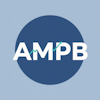
    </div>
    <div style="text-align:center; margin-bottom:20px">
        <h1 style="color:#9E0B0F; font-size:26px; margin-bottom:5px">Análisis de modelos predictivos en bolsa</h1>
        <h3 style="color:#D64550; font-size:22px; margin-top:0">Copyright (C) 2024-2025 MegaStorm Systems</h3>
    </div>
    <div style="width:192px; height:59px">
        <p style="max-width:100%; max-height:100%">
    </div>
</div>

<div style="width:60%; margin:0 auto; background-color:#E8E8E8; padding:20px; border-radius:10px; border:1px solid #D0D0D0; margin-bottom:20px; color:#333333; line-height:1.5; box-shadow:0 2px 4px rgba(0,0,0,0.05)">
    <p style="margin:0; font-size:15px">    
    This software is provided "as-is", without any express or implied<br>
    warranty. In no event will the authors be held liable for any damages<br>
    arising from the use of this software.<br><br>
    Permission is granted to anyone to use this software for any purpose,<br>
    including commercial applications, and to alter it and redistribute it<br>
    freely, subject to the following restrictions:<br><br>
    1. The origin of this software must not be misrepresented; you must not<br>
    claim that you wrote the original software. If you use this software<br>
    in a product, an acknowledgment in the product documentation would be<br>
    appreciated but is not required.<br>
    2. Altered source versions must be plainly marked as such, and must not be<br>
    misrepresented as being the original software.<br>
    3. This notice may not be removed or altered from any source distribution.
    </p>
</div>

<div style="text-align:center">
    <h2 style="font-size:24px; color:#9E0B0F; margin:0">Predictor SARIMAX v2.4</h2>
</div>

</div>

In [ ]:
# Importar librerías
import os
import argparse
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import ndiffs, nsdiffs
import time
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

from ampblib import AMPBConfig, processData, generateEvaluation, updateNextDayExog, createReport, getExogVars, reverseTransformPredictions, createModelIdentity

In [ ]:
# 0. PARÁMETROS CONFIGURABLES
model_name = "SARIMAX"
model_version = "v2.4"

# Por defecto, permite ejecucion interactiva
default_transformation = "RetLog" # "None", "Log", "RetLog", "YeoJohnson"
default_exog_scaling = "None"   # "None", "Standard", "MinMax"
default_exog_set_id = 23456    # 1="Directos", 2="IndicadoresTecnicos", 3="BigTech", 4="IndicesBursatiles", 5="IndicadoresEconomicos", 6="AnalisisSentimiento"

# Estos son fijos e internos, no los exponemos
nombre_archivo = "NVDA_2015-01-05_2025-05-23_SA.csv"
test_size = 60              # Número de días para el conjunto de test
optimize_orders = True     # True para optimizar (p,d,q) con auto_arima, False para usar valores fijos
fixed_order = (0,0,3)       # Orden (p,d,q) si optimizar = False.                             
fixed_seasonal_order = (0,0,0,5)  # Orden estacional (P,D,Q,s) si optimize_orders = False
winsorization_value = 0.005  # Aplicar winsorización (solo si hay alguna transformacion)
run_backtesting = True      # True para Backtesting con Walk-Forward y False para no realizar este test (utiliza orders optimizados anteriores o fijos)
retrain_interval = 5        # Reentrenar modelo completo cada n días en backtesting. 5 es un valor adecuado, acelera la velocidad a cambio de perder un ~6% de rendimiento.

# Argumentos de línea de comandos  
if AMPBConfig.INTERACTIVE:
    transformation = default_transformation
    exog_scaling = default_exog_scaling
    exog_set_id = default_exog_set_id
else:
    parser = argparse.ArgumentParser(description='Ejecuta modelo SARIMAX.')
    parser.add_argument('--transformation', type=str, default=default_transformation, choices=['None', 'Log', 'RetLog', 'YeoJohnson'])
    parser.add_argument('--exog_scaling', type=str, default=default_exog_scaling, choices=['None', 'Standard', 'MinMax'])
    #parser.add_argument('--exog_set_id', type=int, default=default_exog_set_id, choices=range(1, 7))
    def valid_exog(x):
        if not all(c in '123456' for c in str(x)): 
            raise argparse.ArgumentTypeError(f"Solo dígitos 1-6: {x}")
        return x
    parser.add_argument('--exog_set_id', type=valid_exog, default=default_exog_set_id)
    args = parser.parse_args()
    transformation = args.transformation
    exog_scaling = args.exog_scaling
    exog_set_id = args.exog_set_id

AMPBConfig.printHeader(title=f"Predictor {model_name} {model_version}", testsize=test_size, 
                     optimize=optimize_orders, backtesting=run_backtesting, transform=transformation,
                     exogscaling=exog_scaling, exogsetid=exog_set_id)

In [ ]:
# 1. CARGA Y PREPARACIÓN DE DATOS
datos = pd.read_csv(nombre_archivo)

# Seleccionar columnas relevantes
mandatory_vars = ['Date','Close', 'Trend']

# Obtenemos lista de exogenas
exog_vars = getExogVars(exog_set_id)
df = datos[mandatory_vars + exog_vars]

# Convertir fechas a datetime
df['Date'] = pd.to_datetime(df['Date'])  

# Verificar y mostrar estadísticas básicas de los datos
print(f"Datos en crudo cargados: {len(df)} registros de {df['Date'].min()} a {df['Date'].max()}.")

# Detectar valores faltantes
missing = df.isna().sum()
missing = missing[missing > 0]

if not missing.empty:
    total_before = len(df)
    print("Valores faltantes por columna (se borrarán estas filas):")
    for col, cnt in missing.items():
        print(f"  • {col}: {cnt} valores faltantes")
    df = df.dropna().reset_index(drop=True)
    total_after = len(df)
    removed = total_before - total_after
    print(f"\nFilas borradas: {removed}")
else:
    print("No se encontraron valores faltantes.")

# Poner Date como indice
df.set_index('Date', inplace=True)
#df = df.asfreq('B', method='pad')  # Se asume que se trata de datos bursátiles (días hábiles)

print(f"\nDatos cargados: {AMPBConfig.COLOR_VALUE}{len(df)}{AMPBConfig.COLOR_RESET} registros. Variables exógenas seleccionadas: {AMPBConfig.COLOR_VALUE}{len(exog_vars)}{AMPBConfig.COLOR_RESET}\n{exog_vars}") 

In [ ]:
# 2. DIVISIÓN ENTRE ENTRENAMIENTO Y TEST

# 2A. Se utiliza el 90% de los datos para entrenamiento y el 10% para test
#split_index = int(len(df) * 0.90)
#df_train = df.iloc[:split_index].copy()
#df_test = df.iloc[split_index:].copy()

# 2B. Separamos datos de entrenamiento y de test por fecha
#split_date = pd.Timestamp('2024-12-01')
#df_train = df.loc[:split_date].copy()
#df_test = df.loc[split_date:].copy()

# 2C. Separamos por numero de dias.
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

# Guardar valores originales (inmutables para referencia futura)
y_train_original = df_train['Close'].copy()
y_test_original = df_test['Close'].copy()
X_train_original = df_train[exog_vars].copy()  
X_test_original = df_test[exog_vars].copy()

# Variables de trabajo (se transformarán/escalarán según configuración)
y_train = df_train['Close']
y_test  = df_test['Close']
X_train = df_train[exog_vars].copy()
X_test = df_test[exog_vars].copy()

print(f"\nDatos divididos:")
print(f"  Entrenamiento: {AMPBConfig.COLOR_VALUE}{len(y_train)}{AMPBConfig.COLOR_RESET} filas (hasta {y_train.index[-1].date()})")
print(f"  Test:          {AMPBConfig.COLOR_VALUE}{len(y_test)}{AMPBConfig.COLOR_RESET} filas (desde {y_test.index[0].date()})")

In [ ]:
# 3. PROCESAR DATOS: TRANSFORMACIONES, ESCALADO, ALINEACION Y ANALISIS DE CALIDAD
# Bajo determinadas circunstancias, puede abortar la ejecucion.
processing_results = processData(
    y_train, y_test, X_train, X_test,
    y_train_original, y_test_original, X_train_original, X_test_original,
    df_test, exog_vars, transformation, exog_scaling,
    winsorization_value=winsorization_value,   
    analyze=False               # True para ejecutar análisis de calidad
)
params_close = processing_results['params_close']
params_exog  = processing_results['params_exog'] 
y_scaler = processing_results['y_scaler']
exog_scaler = processing_results['exog_scaler']
df_test_aligned = processing_results['df_test_aligned']
prediction_max_limit = processing_results['prediction_max_limit']
quality_results = processing_results['quality_results']

In [ ]:
# 4. ENTRENAMIENTO SARIMAX (SOLO EN TRAIN DATA)
    
# 4A. OPTIMIZACIÓN DE PARÁMETROS CON AUTO_ARIMA
if optimize_orders:
    # Definición de parámetros dinámicos según la transformación
    if transformation == "RetLog":
        d_values = [0]
        D_values = [0]
        print(f"Transformación 'RetLog': forzando d=0, D=0 (serie ya diferenciada)")        
    else:
        # Para otras transformaciones, forzar exploración explícita de d y D
        suggested_d = ndiffs(y_train, test='kpss')
        suggested_D = nsdiffs(y_train, test='ch', m=5)  # Test de estacionariedad estacional
        max_d = min(2, suggested_d)  # Máximo: sugerido + 1, pero no más de 2
        max_D = min(1, suggested_D)  # Máximo: sugerido + 1, pero no más de 1
        d_values = list(range(0, max_d + 1))  # [0, 1, 2] según max_d
        D_values = list(range(0, max_D + 1))  # [0, 1] según max_D
        print(f"Transformación '{transformation}': ndiffs sugiere d={suggested_d}, nsdiffs sugiere D={suggested_D}")
        print(f"Forzando auto_arima a explorar d={d_values}, D={D_values}")

    print("\nBuscando el mejor orden para SARIMAX...")
    
    # Búsqueda manual por combinaciones de d y D para asegurar exploración completa
    best_aic = np.inf
    best_model = None
    
    for d_val in d_values:
        for D_val in D_values:
            print(f"\n--- Explorando d={d_val}, D={D_val} ---")
            try:
                temp_model = pm.auto_arima(y_train,
                                           X=X_train,                     # Variables exógenas
                                           d=d_val,                       # Valor fijo para d
                                           D=D_val,                       # Valor fijo para D
                                           method='lbfgs',                # Usa el optimizador L-BFGS (rápido y eficiente)
                                           start_p=0, max_p=3,
                                           start_q=0, max_q=3,
                                           start_P=0, max_P=2,
                                           start_Q=0, max_Q=2,
                                           m=5,                           # Frecuencia estacional (5 para datos bursátiles semanales)
                                           seasonal=True,                  
                                           stepwise=True,                 # Búsqueda inteligente
                                           suppress_warnings=True,        # Suprimir warnings de convergencia, etc.
                                           error_action='ignore',         # Ignorar órdenes que fallen
                                           trace=False,
                                           information_criterion='aic',   # Criterio para seleccionar el mejor modelo.
                                           n_jobs=-1                      # Paraleliza la ejecución
                                          )
                
                if temp_model.aic() < best_aic:
                    best_aic = temp_model.aic()
                    best_model = temp_model
                    print(f"Nuevo mejor modelo encontrado: {temp_model.order}{temp_model.seasonal_order} con AIC={best_aic:.3f}")
                    
            except Exception as e:
                print(f"Error explorando d={d_val}, D={D_val}: {str(e)[:100]}...")
                continue
    
    auto_model = best_model
    
    best_order = auto_model.order
    best_order_seasonal = auto_model.seasonal_order    
    print(f"\nAuto-ARIMA encontró órdenes óptimos: {best_order} y {best_order_seasonal}")

else:   
    # Usar órdenes fijos
    best_order = fixed_order
    best_order_seasonal = fixed_seasonal_order
    print(f"Utilizando órdenes fijos: {best_order} y {best_order_seasonal}")

# 4B. AJUSTE DE SARIMAX    
print("Ajustando modelo...")
best_model = SARIMAX(y_train, exog=X_train, order=best_order, seasonal_order=best_order_seasonal,
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, method='lbfgs')

# Información del modelo
model_title, model_hash = createModelIdentity(model_name, model_version, f"{best_order}{best_order_seasonal}", transformation, exog_scaling, exog_set_id)
print(f"\n{AMPBConfig.COLOR_INFO}Modelo {model_name}{model_version}:{AMPBConfig.COLOR_RESET}")
print(f" Order (p,d,q): {best_order}")
print(f" Seasonal Order (P,D,Q,s): {best_order_seasonal}")
print(f" Título: '{model_title}' | HashID: {model_hash}\n")

In [ ]:
# 5A. PREDICCIÓN Y EVALUACIÓN EN EL CONJUNTO DE TEST (VALIDACIÓN ESTÁTICA)
print(f"{AMPBConfig.COLOR_INFO}Validación Estática{AMPBConfig.COLOR_RESET}")

# Predicción del período de test completo
forecast_scaled_transformed = best_model.get_forecast(steps=len(y_test), exog=X_test).predicted_mean
forecast_scaled_transformed.index = y_test.index

# Aplicar pipeline de des-transformación
forecast_original = reverseTransformPredictions(
    forecast_scaled_transformed,
    y_train_original.iloc[-1],
    y_scaler,
    transformation, 
    params_close,
    prediction_max_limit
)

# Predicción día siguiente
X_next_day = updateNextDayExog(
    X_test,
    feature_original_close=y_test_original.iloc[-1],          
    transformation=transformation,
    params_exog=params_exog,
    exog_scaler=exog_scaler,
    prev_open_original = (
        X_test_original['Open'].iloc[-1]
        if transformation == "RetLog" and 'Open' in X_test_original.columns
        else None
    )
)

next_day_date = y_test.index[-1] + pd.tseries.offsets.BDay(1)
X_next_day.index = [next_day_date]
next_forecast = best_model.get_forecast(steps=1, exog=X_next_day).predicted_mean
next_day_forecast_original = reverseTransformPredictions(
    next_forecast, 
    y_test_original.iloc[-1], # Para la referencia del día siguiente, usar el último valor real del test
    y_scaler,
    transformation,
    params_close,
    prediction_max_limit
).iloc[0]

In [ ]:
# 5B. EVALUACIÓN Y GRÁFICAS 
# Evaluación de validación estática
sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc = generateEvaluation(
    y_test_original, forecast_original, df_test_aligned, model_title, model_hash, 
    next_day_date, next_day_forecast_original, "Static Validation")

# Guardar reporte
createReport(model_name, "SV", f"{transformation}_{exog_scaling}_{exog_set_id}", model_title, model_hash, sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc)

In [ ]:
# 6. EVALUACIÓN CON CROSS VALIDATION (VALIDACIÓN CRUZADA)
# Opcional, no disponible en este modelo.

In [ ]:
# 7A. MODO DE BACKTESTING: PREDICCIÓN DÍA A DÍA (VALIDACIÓN BACKTESTING)
if run_backtesting:    
    model_title_backtest = f'{model_title} (Backtesting [{retrain_interval}d])'
    print(f"\n{AMPBConfig.COLOR_INFO}Modo Backtesting con Walk-Forward (Retrain cada {retrain_interval} días){AMPBConfig.COLOR_RESET}")
    
    # Inicializar historiales
    history_y = y_train.copy()              # Datos transformados/escalados para el modelo
    history_X = X_train.copy()              # Datos transformados/escalados para el modelo
    history_y_original = y_train_original.copy()  # Valores originales para referencias
    history_X_original = X_train_original.copy() 
    
    predictions_original_bt = []
    model_bt = None  # Modelo que se reutilizará entre reentrenamientos
    
    bt_start = time.time()
    for t in range(len(y_test)):
        print(f" Backtesting: {t+1}/{len(y_test)}", end='')
        
        # Reentrenar el modelo cuando sea necesario
        if t % retrain_interval == 0:   
            print(f" [Reentrenando...]", end='')
            model_bt = SARIMAX(history_y, exog=history_X, order=best_order, 
                               seasonal_order=best_order_seasonal,
                               enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=50)
            print(f" [✓]", end='')
        
        print(f"")  # Nueva línea
        
        # Preparar exógenas propagadas
        X_current_propagated = updateNextDayExog(
            history_X,
            feature_original_close=history_y_original.iloc[-1],        # Close_{t-1} original
            transformation=transformation,
            params_exog=params_exog,
            exog_scaler=exog_scaler,            
            prev_open_original = (
                history_X_original['Open'].iloc[-1]
                if transformation == "RetLog" and 'Open' in X_test_original.columns
                else None
            )
        )
        
        # Predecir 1 paso adelante 
        forecast_step_scaled_transformed = model_bt.get_forecast(steps=1, exog=X_current_propagated).predicted_mean
        
        # Des-transformar usando pipeline centralizado 
        reference_val = history_y_original.iloc[-1]
        forecast_step_original = reverseTransformPredictions(
            forecast_step_scaled_transformed,
            reference_val,
            y_scaler,
            transformation,
            params_close,
            prediction_max_limit
        ).iloc[0]
                
        # Guardar predicción
        predictions_original_bt.append(forecast_step_original)
        
        # Actualizar historiales con datos reales del día t
        history_y = pd.concat([history_y, y_test.iloc[t:t+1]])
        history_X = pd.concat([history_X, X_test.iloc[t:t+1]])
        history_y_original = pd.concat([history_y_original, pd.Series([y_test_original.iloc[t]], index=[y_test_original.index[t]])])
        history_X_original = pd.concat([history_X_original, X_test_original.iloc[t:t+1]])
    
    # Estadísticas de reentrenamiento
    total_retrains = (len(y_test) + retrain_interval - 1) // retrain_interval 
    print(f" Backtesting completado en {time.time() - bt_start:.1f}s")
    print(f" Reentrenamientos realizados: {total_retrains} (cada {retrain_interval} días)\n")
    
    # Crear Serie con predicciones del backtesting
    forecast_backtest_original = pd.Series(predictions_original_bt, index=y_test_original.index)

In [ ]:
# 7B. MODO DE BACKTESTING: PREDICCIÓN SIGUIENTE DÍA
if run_backtesting:
    X_next_day_bt = updateNextDayExog(
        history_X,
        feature_original_close=history_y_original.iloc[-1],
        transformation=transformation,
        params_exog=params_exog,
        exog_scaler=exog_scaler,
        prev_open_original = (
                history_X_original['Open'].iloc[-1]
                if transformation == "RetLog" and 'Open' in X_test_original.columns
                else None
            )
    )
    X_next_day_bt.index = [next_day_date]
    # Predecir y des-transformar usando pipeline centralizado
    next_forecast_scaled_transformed_bt = model_bt.get_forecast(steps=1, exog=X_next_day_bt).predicted_mean
    next_day_forecast_val_bt_original = reverseTransformPredictions(
        next_forecast_scaled_transformed_bt, 
        history_y_original.iloc[-1], # Predicción para el día siguiente usando el último modelo del backtesting
        y_scaler, 
        transformation, 
        params_close,
        prediction_max_limit
    ).iloc[0]

In [ ]:
# 7C. MODO DE BACKTESTING: EVALUACIÓN Y GRÁFICAS 
if run_backtesting:
    # Evaluación del backtesting
    bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc = generateEvaluation(
        y_test_original, 
        forecast_backtest_original, 
        df_test_aligned, 
        model_title_backtest, 
        model_hash,
        next_day_date, 
        next_day_forecast_val_bt_original, 
        "Backtesting"
    )

    # Guardar informe del backtesting
    createReport(model_name, "BT", f"{transformation}_{exog_scaling}_{exog_set_id}", model_title, model_hash, bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc)